# Generate Synthetic Data

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/orig/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/orig/modfiles",
    cell_name="Simple_Spiker_orig",
    g_names = ["gnabar_hh_orig", "gkbar_hh_orig", "gl_hh_orig"]
)

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name="spiker_original",
        cell= target_cell,
        sim_params= SimParams(
            h_v_init=-67.0,  # Consistent with nrngui settings
            h_tstop=400,     # Simulation time in ms
            h_dt=1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1],   # Current injection amplitude
            CI_dur=350,      # Duration of current injection
            CI_delay=50,     # Delay before current injection
            set_g_to=[]
        ),
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
h.celsius: 6.3
h.tstop: 400.0
h.dt: 1.0
h.steps_per_ms: 1.0
h.v_init: -67.0
inj.amp = 0.1 | inj.dur = 350 | inj.delay = 50
/home/mwsrgf/proj/ACT/model/spiker_original/synthetic_0.1_


(400,)


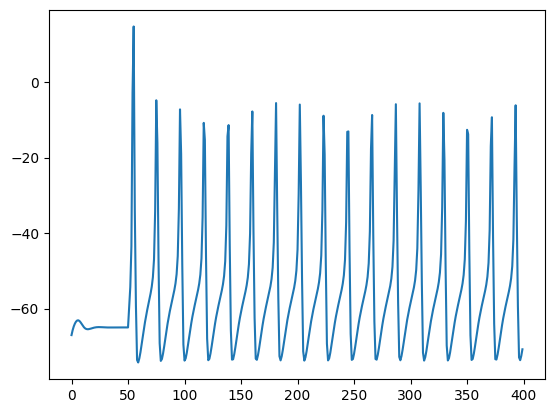

In [2]:
import numpy as np
dataset = np.load('./model/spiker_original/synthetic_0.1_/combined_out.npy')

V = dataset[0,:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

In [3]:
sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name="spiker_original",
        cell= target_cell,
        sim_params= SimParams(
            h_v_init = -54.3,
            h_tstop = 1000,
            h_dt = 1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.01],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 600,
            CI_delay = 200,
            set_g_to=[]
        ),
        optim_params = OptimizationParameters(
            blocked_channels= ["gnabar_hh_orig", "gkbar_hh_orig"]
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: ['gnabar_hh_orig', 'gkbar_hh_orig']
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
h.celsius: 6.3
h.tstop: 1000.0
h.dt: 1.0
h.steps_per_ms: 1.0
h.v_init: -54.3
inj.amp = -0.01 | inj.dur = 600 | inj.delay = 200
/home/mwsrgf/proj/ACT/model/spiker_original/synthetic_-0.01_


(1000,)


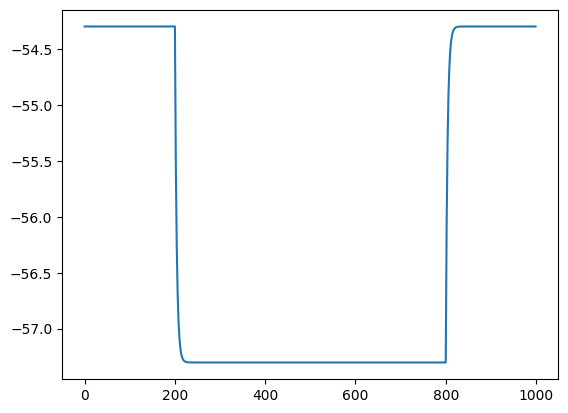

In [4]:
import numpy as np
dataset = np.loadtxt('./model/spiker_original/target/passive_data.csv', delimiter=',', skiprows=1)

V = dataset[:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

# Get Passive Properties

In [5]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/orig/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/orig",
    cell_name="Simple_Spiker_orig",
    g_names = ["gnabar_hh_orig", "gkbar_hh_orig", "gl_hh_orig"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=SimParams(
            h_v_init = -54.3,
            h_tstop = 1000,
            h_dt = 1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.01],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 600,
            CI_delay = 200,
            set_g_to=[]
        ),
    trace_filepath='./model/spiker_original/target/passive_data.csv',
    leak_conductance_variable="gl_hh_orig",
    leak_reversal_variable="el_hh_orig"
)

In [6]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-54.3, R_in=300.2017185225114, tau=4.0, Cm=1, g_bar_leak=0.0003, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_orig', leak_reversal_variable='el_hh_orig')


# Run Original Pipeline with Passive Prediction

In [7]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

mod = ACTModule(
    ModuleParameters(
        module_folder_name="spiker_original",
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= SimParams(
            h_v_init=-67.0,  # Consistent with nrngui settings
            h_tstop=400,     # Simulation time in ms
            h_dt=1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1],   # Current injection amplitude
            CI_dur=350,      # Duration of current injection
            CI_delay=50,     # Delay before current injection
            set_g_to=[]
        ),
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_orig", low=0.12, high=0.12, n_slices=2),
                OptimizationParam(param="gkbar_hh_orig", low=0.036, high=0.036, n_slices=2),
                OptimizationParam(param="gl_hh_orig", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ]
        )
    )
)

In [8]:
predicted_g_data_folder = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 4
Total number of proccessors: 192
MECHANISMS already loaded.
h.celsius: 6.3h.celsius: 6.3h.celsius: 6.3h.celsius: 6.3



h.tstop: 400.0h.tstop: 400.0h.tstop: 400.0h.tstop: 400.0



h.dt: 1.0h.dt: 1.0h.dt: 1.0h.dt: 1.0



h.steps_per_ms: 1.0h.steps_per_ms: 1.0h.steps_per_ms: 1.0h.steps_per_ms: 1.0


h.v_init: -67.0
h.v_init: -67.0h.v_init: -67.0
h.v_init: -67.0


Setting el_hh_orig = -54.3Setting el_hh_orig = -54.3
Setting el_hh_orig = -54.3
Setting el_hh_orig = -54.3Setting gl_hh_orig = 0.0003
Setting gl_hh_orig = 0.0003


Setting gl_hh_orig = 0.0003Setting gl_hh_orig = 0.0003Capacitance (cm) of soma: 1.0Capacitance (cm) of soma: 1.0



Capacitance (cm) of soma: 1.0Setting cm = 1Capacitance (cm) of soma: 1.0Setting cm = 1



Setting cm = 1inj.amp = 0.1 | inj.dur = 350 | inj.delay = 50Setting cm = 1inj.amp = 0.1 | inj.dur = 350 | inj.delay = 50



inj.amp = 0.1 | inj.dur = 350 | inj.delay = 50
inj.a

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
Evaluating random forest
MAE: 0.000000 (0.000000)
Predicted Conductances for each current injection intensity: [[0.12   0.036  0.0003]]
SIMULATING PREDICTIONS
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
h.celsius: 6.3
h.tstop: 400.0
h.dt: 1.0
h.steps_per_ms: 1.0
h.v_init: -67.0
Setting el_hh_orig = -54.3
Setting gl_hh_orig = 0.0003

Capacitance (cm) of soma: 1.0Setting cm = 1
inj.amp = 0.1 | inj.dur = 350 | inj.delay = 50
/home/mwsrgf/proj/ACT/model/spiker_original/prediction_eval0
SELECTING BEST PREDICTION
{'gnabar_hh_orig': 0.120000000000002, 'gkbar_hh_orig': 0.036000000000001, 'gl_hh_orig': 0.0003}


In [9]:
print(train_cell.predicted_g)

{'gnabar_hh_orig': 0.120000000000002, 'gkbar_hh_orig': 0.036000000000001, 'gl_hh_orig': 0.0003}


In [10]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_folder, "./model/spiker_original/target", "./model/spiker_original", [0.1])
ACTPlot.plot_fi_comparison("./model/spiker_original/results/frequency_data_0.npy", [0.1])